# Satellitenfilter für HACI-Objekte

Da wir für die Suche nach isolierter Konvektion das RADOLAN-RX-Komposit benutzen, dürfte eine Vielzahl der gefundenen Objekte aus nichtmeteorologischen Echos bestehen.

Die einfachste Möglichkeit solche Echos zu elminieren ist wahrscheinlich zu schauen, welche Echos unter Wolken liegen oder nicht. Die meisten nichtmeteorologischen Echos sollten damit zu elminieren sein, weil sie nicht im Bereich von Wolken liegen. 

## 1. Grundidee

Die Grundidee ist also folgende:

1. Suche Radarechos, die die Bedingungen des HACI-Algorithmus erfüllen.
2. Prüfe, ob sie im NWCSAF-Wolkenmaskenprodukt in einem bewölkten Pixel liegen.

Dabei ergeben sich zwei Schwierigkeiten:

1. Das NWC&thinsp;SAF-CMa-Produkt ist nicht für alle Tage im Zeitraum 2008 bis 2017 vorhanden.
2. Durch die Parallaxenverschiebung kann es passieren, dass ein meteorologisches Echo als außerhalb einer Wolke liegend betrachtet wird, weil die zugehörige Wolke im Satellitenbild parallaxenverschoben ist.

Die erste Schwierigkeit lässt sich dadurch lösen, dass für die fehlenden Zeitschritte das CMa-Produkt noch berechnet wird oder, dass am Tag, eine näherungsweise Wolkenmaske aus einem sichtbaren Kanal gefiltert wird.

Der zweiten Schwierigkeit kann durch die Berechnung der genauen Parallaxenverschiebung begegnet werden oder durch einen schnelleren Näherungsansatz. Die durch das NWC&thinsp;SAF-CTTH-Produkt gegebene maximal mögliche Wolkenhöhe liegt im Bereich um 14&thinsp;km. Das entspricht in Deutschland ungefähr einer maximal möglichen Verschiebung von vier MSG-Standardpixeln. Da Deutschland nördlich vom Stelliten liegt werden die Wolken nur Richtung Norden und westlich von 9,5°O leicht nach Westen und östlich davon leicht nach Osten verschoben. Daraus folgt, dass bewölkte Pixel nur in einem Umkreis von maximal vier MSG-Standardpixeln Richtung Norden und Osten oder Westen zu suchen ist. Das entspricht in Deutschland im Mittel ca.13&thinsp;km in Ost-West-Richtung und ca. 25&thinsp;km in Nord-Süd-Richtung.

In [1]:
import numpy as np
import pandas as pd
import MSGtools as mst
import datetime as dt

from standard_config import *

import sys
sys.path.append("{}/utils/io".format(local_home_path))
import io_config as ioc

import matplotlib.pyplot as plt
from io_tools import radolan

from scipy.interpolate import griddata
import tqdm

from skimage.draw import ellipse

from analysis_tools import grid_and_interpolation as gi
import geooperations as go

import load_satellite_data as lsd
from analysis_tools import make_hrv_upscaling as mhu
from scipy import ndimage as ndi

ModuleNotFoundError: No module named 'geooperations'

In [ ]:
r = radolan.Radolan()

In [ ]:
def time2index(hour,minute,dt=5):
    t = ((hour*60) + minute) // dt
    
    return t

def index2time(ind,dt=5):
    hour,minute = divmod(ind*dt,60)
    
    return (hour,minute)

def centre_from_haci_object(haci_object):
    centre_l = (haci_object.l0 + haci_object.l1)//2
    centre_c = (haci_object.c0 + haci_object.c1)//2
    
    return (centre_l,centre_c)

def half_ellipse(r,c,r_radius,c_radius,nrows,ncols,shape=None, rotation=0.0,origin='lower'):
    from skimage.draw import ellipse
    
    full_ellipse = ellipse(r,c,r_radius,c_radius,shape,rotation)
    
    if origin in ['lower','upper']:
        if origin == 'lower':
            ellipse_rows = full_ellipse[0][np.where(full_ellipse[0]>=r)]
            ellipse_cols = full_ellipse[1][np.where(full_ellipse[0]>=r)]
        else:
            ellipse_rows = full_ellipse[0][np.where(full_ellipse[0]<=r)]
            ellipse_cols = full_ellipse[1][np.where(full_ellipse[0]<=r)]
    
    h_ellipse = (np.clip(ellipse_rows,0,nrows),np.clip(ellipse_cols,0,ncols))
    
    return h_ellipse

def cloudiness_filter(centre_row,centre_column,time,r_radius,c_radius,nrows,ncols,cloud_mask=False,origin='upper'):
    
    object_ellipse = half_ellipse(centre_row,
                                  centre_column,
                                  r_radius,c_radius,
                                  nrows,ncols,
                                  origin=origin)
    
    if np.all(cloud_mask) == False:
        cloud_mask = mst.get_nwcsaf_prod("CMa",time,calibrate=True)
    
    cloud_mask_values = np.unique(cloud_mask[object_ellipse])
    
    if np.any(cloud_mask_values>1):
        return 1
    elif np.all(cloud_mask_values==1):
        return 0
    else:
        return -1
    
def collect_haci_dates(haci_cases):
    haci_dates = []

    for i,r in haci_cases.iterrows():
        d = dt.datetime.strptime("{}_{}".format(r.date,r.time),"%Y-%m-%d_%H:%M")
        haci_dates.append(d)
        
    return np.unique(haci_dates)

## 2. Beispielfalltag

Als Beispiel sehen wir uns den 20.06.2013 an. Dafür laden wir alle HACI-Falldaten für diesen Tag.

In [139]:
haci_cases = pd.read_csv("{}/haci-2013-06-20-bbox.dat".format(ioc.haci_bbox_data_path),sep="\s+")

Diese Daten sind nur auf den Abstand zu existerenden Niederschlagsbereichen gefiltert. Wir filtern sie jetzt noch auch die Mindestdauer von 30 Minuten.

In [140]:
haci_cases = haci_cases[haci_cases.t1 - haci_cases.t0 >= 6]

## 2.1 Wolkenmaske auf RADOLAN-Gitter

Als nächstes laden wir das NWC&thinsp;SAF-CMa-Produkt für den Tag und den RADOLAN-RX-Ausschnitt und reprojizieren diese Ausschnitte auf das RADOLAN-RX-Gitter.

In [ ]:
rmin = 90
rmax = 355
cmin = 340
cmax = 640

In [ ]:
slon,slat = mst.get_msg_lon_lat('eu')
slon_rx = slon[rmin:rmax,cmin:cmax]
slat_rx = slat[rmin:rmax,cmin:cmax]

In [143]:
haci_dates =  collect_haci_dates(haci_cases)

In [144]:
cloud_masks_rx = {d.strftime("%Y-%m-%d_%H:%M") :[] for d in haci_dates}

In [145]:
for i,t in tqdm.tqdm(enumerate(haci_dates),total=len(haci_dates)):
    cma = mst.get_nwcsaf_prod("CMa",t,calibrate=True)[rmin:rmax,cmin:cmax]
    dstring = t.strftime("%Y-%m-%d_%H:%M")
    cloud_masks_rx[dstring] = griddata((slon_rx.ravel(),slat_rx.ravel()), cma.ravel(), (r.lon, r.lat), method='nearest')

100%|██████████| 95/95 [01:53<00:00,  1.19s/it]


Als nächstes müssen wir alle verbliebenen HACI-Objekt durchlaufen und prüfen, ob sie in einem bewölkten Pixel (Wolkenmaske > 1) liegen oder zumindes in einem Umkreis von 25&thinsp;px&thinsp;&wedgeq;&thinsp;25&thinsp;km bewölkte Pixel liegen, die sich dem HACI-Objekt zuordnen lassen.

In [146]:
haci_object = haci_cases.iloc[1]

Als nächstes wandeln wir die Zeitangabe um, um die richtige Wolkenmaske zu suchen.

In [34]:
tstring = "{}_{}".format(haci_object.date,haci_object.time)

Dann ermitteln wir den Mitelpunkt der Umgebungsbox des HACI-Objekts und erzeugen eine Ellipse darum.

In [35]:
object_centre = centre_from_haci_object(haci_object)

In [36]:
object_ellipse = ellipse(object_centre[0],object_centre[1],25,13)

In [37]:
object_ellipse

(array([314, 314, 314, ..., 362, 362, 362]),
 array([171, 172, 173, ..., 175, 176, 177]))

Uns interessiert allerdings nur der Bereich nördlich vom Mittelpunkt.

In [38]:
ellipse_rows = object_ellipse[0][np.where(object_ellipse[0]>object_centre[0])]
ellipse_cols = object_ellipse[1][np.where(object_ellipse[0]>object_centre[0])]
object_ellipse = (ellipse_rows,ellipse_cols)

Wenn in der durch die Ellipse angegeben Bereich in der Wolkenmaske bewölkte Pixel sind, ist das zum HACI-Objekt gehörende Radarecho wahrscheinlich ein meteorologisches.

In [39]:
np.unique(cloud_masks_rx[tstring][object_ellipse])

array([3.], dtype=float32)

In [40]:
test = cloud_masks_rx[tstring].copy()
test[object_ellipse]=4

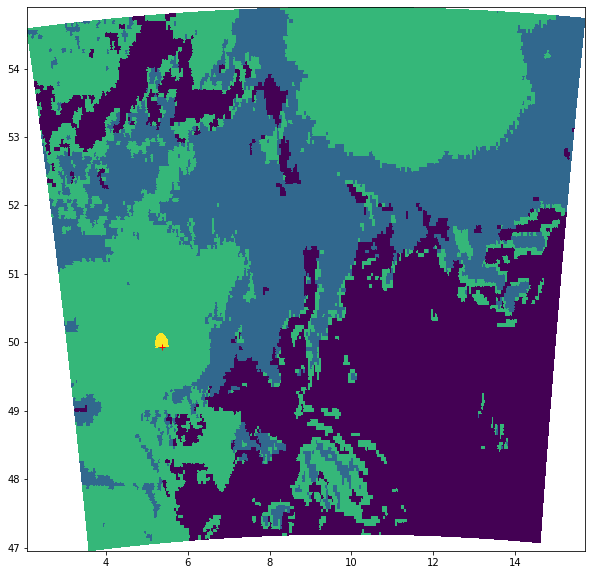

In [41]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.pcolormesh(r.lon,r.lat,test)
ax.plot(r.lon[object_centre[0],object_centre[1]],
        r.lat[object_centre[0],object_centre[1]],'r+')

Das scheint soweit zu funktionieren. Dann machen wir das auch für die anderen HACI-Objekte.

In [203]:
object_in_clouds_rx = np.zeros((len(haci_cases.time)),dtype="int")

j = 0
for i,haci_object in haci_cases.iterrows():
    object_centre = centre_from_haci_object(haci_object)
    
    object_ellipse = half_ellipse(object_centre[0],
                                  object_centre[1],
                                  25,13,899,899)
    
    tstring = "{}_{}".format(haci_object.date,haci_object.time)
    
    cloud_mask_values = np.unique(cloud_masks_rx[tstring][object_ellipse])   
    
    if np.any(cloud_mask_values>1):
        object_in_clouds_rx[j] = 1
    
    j += 1

In [206]:
haci_cases = haci_cases.assign(in_cloud_rx=object_in_clouds_rx)

In [207]:
haci_cases[haci_cases.in_cloud_rx==0]

,date,time,id,flags,t0,t1,l00,l01,c00,c01,l0,l1,c0,c1,in_cloud_rx,msg_eu_l,msg_eu_c,in_cloud_msg,in_cloud_diff
412,2013-06-20,05:00,1065,0,60,122,278,284,548,558,278,348,548,600,0,187,526,0,0
543,2013-06-20,06:35,1358,0,79,114,278,279,548,549,271,325,548,573,0,190,522,0,0
779,2013-06-20,09:20,1911,0,112,120,517,518,762,764,517,518,762,764,0,157,583,0,0
798,2013-06-20,09:35,1948,0,115,126,321,329,554,573,321,349,554,575,0,184,523,0,0
995,2013-06-20,12:20,2444,0,148,160,674,679,517,522,673,709,517,524,0,129,509,0,0
1193,2013-06-20,14:20,2840,0,172,181,718,724,633,636,718,741,633,644,0,124,545,0,0
1308,2013-06-20,15:20,3055,0,184,192,748,750,645,647,748,767,645,652,0,120,548,0,0
1391,2013-06-20,16:05,3249,0,193,288,208,603,161,508,173,659,141,547,0,172,457,0,0


Einige der gefundenen HACI-Objekte des Beispieltages sind nicht nah genug an bewölkten Pixeln und damit wahrscheinlich nicht mit meteorlogischen Echos verknüpft. Aber das sollten wir uns im Detail ansehen. Außerdem dauert es relativ lange die Wolkenmasken auf das RADOLAN-Gitter zu projizieren. Pragamtischer ist es, die Koordinaten der Umgebungsbox der HACI-Objekte in das MSG-Gitter umzurechnen und dann direkt die Wolkenmasken zu benutzen.

## 2.2 Auf MSG-Gitter

Zuerst berechnen wir die Mittelpunkte der Umgebungsboxen und wandeln deren Koordinaten dann in das MSG-Gitter um.

In [151]:
slon,slat = mst.get_msg_lon_lat('eu')

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [152]:
c_r,c_c = centre_from_haci_object(haci_cases)

In [153]:
c_lon = r.lon[c_r.values,c_c.values]
c_lat = r.lat[c_r.values,c_c.values]

In [154]:
msg_idx = gi.get_index_kdtree(np.array([[c_lat],[c_lon]]),slat,slon)

In [155]:
msg_r = []
msg_c = []

for idx in msg_idx:
    msg_r.append(idx[0][0])
    msg_c.append(idx[1][0])

In [156]:
haci_cases = haci_cases.assign(msg_eu_l=msg_r, msg_eu_c = msg_c)

In [157]:
haci_dates = collect_haci_dates(haci_cases)

Als nächstes laden wir die Wolkenmasken.

In [158]:
cloud_masks = {d.strftime("%Y-%m-%d_%H:%M") :[] for d in haci_dates}

In [159]:
for i,t in tqdm.tqdm(enumerate(haci_dates),total=len(haci_dates)):
    cma = mst.get_nwcsaf_prod("CMa",t,calibrate=True)
    dstring = t.strftime("%Y-%m-%d_%H:%M")
    cloud_masks[dstring] = cma

100%|██████████| 95/95 [00:00<00:00, 169.15it/s]


Danach gehen wir ähnlich vor wie bei den reprojizierten Wolkenmasken, nur jetzt nehmen wir als Ellipsenradius 4&thinsp;px.

In [184]:
object_in_clouds_msg_grid = np.zeros((len(haci_cases.time)),dtype="int")

j = 0
for i,haci_object in haci_cases.iterrows():
    object_centre = centre_from_haci_object(haci_object)
    
    object_ellipse = half_ellipse(haci_object.msg_eu_l,
                                  haci_object.msg_eu_c,
                                  5,5,600,800,origin='upper')
    
    tstring = "{}_{}".format(haci_object.date,haci_object.time)
    
    cloud_mask_values = np.unique(cloud_masks[tstring][object_ellipse])
    
    if np.any(cloud_mask_values>1):
        object_in_clouds_msg_grid[j] = 1
        
    j += 1

In [208]:
haci_cases = haci_cases.assign(in_cloud_msg=object_in_clouds_msg_grid)

Jetzt können wir das Ergebnis beider Ansätze vergleichen.

In [209]:
np.unique(haci_cases.in_cloud_msg.values - haci_cases.in_cloud_rx.values)

array([0])

Leider gibt es Unterschiede. Wären die Ergebnisse überall gleich wäre die Differenz immer gleich null. Es gibt aber Fälle wo es Unterschiede gibt. Warum das so ist, sehen wir uns jetzt an.

In [210]:
haci_cases = haci_cases.assign(in_cloud_diff = haci_cases.in_cloud_msg - haci_cases.in_cloud_rx)

In [211]:
haci_cases.in_cloud_diff.value_counts()

0    128
Name: in_cloud_diff, dtype: int64

Beide Ansätze liefern das gleiche Ergebnis.

## 3. Weitere Beispielfalltag

In [212]:
haci_cases = pd.read_csv("{}/haci-2013-06-19-bbox.dat".format(ioc.haci_bbox_data_path),sep="\s+")

In [213]:
haci_cases = haci_cases[haci_cases.t1 - haci_cases.t0 >= 6]

In [214]:
c_r,c_c = centre_from_haci_object(haci_cases)
c_lon = r.lon[c_r.values,c_c.values]
c_lat = r.lat[c_r.values,c_c.values]

msg_idx = gi.get_index_kdtree(np.array([[c_lat],[c_lon]]),slat,slon)

msg_r = []
msg_c = []

for idx in msg_idx:
    msg_r.append(idx[0][0])
    msg_c.append(idx[1][0])

In [215]:
haci_cases = haci_cases.assign(msg_eu_l=msg_r, msg_eu_c = msg_c)

In [216]:
haci_dates = collect_haci_dates(haci_cases)

In [217]:
cloud_masks = {d.strftime("%Y-%m-%d_%H:%M") :[] for d in haci_dates}

for i,t in tqdm.tqdm(enumerate(haci_dates),total=len(haci_dates)):
    cma = mst.get_nwcsaf_prod("CMa",t,calibrate=True)
    dstring = t.strftime("%Y-%m-%d_%H:%M")
    cloud_masks[dstring] = cma

  0%|          | 0/94 [00:00<?, ?it/s]/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
100%|██████████| 94/94 [00:00<00:00, 166.43it/s]


In [218]:
object_in_clouds_msg_grid = np.zeros((len(haci_cases.time)),dtype="int")

j = 0
for i,haci_object in haci_cases.iterrows():
    tstring = "{}_{}".format(haci_object.date,haci_object.time)
    t = dt.datetime.strptime("{}_{}".format(haci_object.date,haci_object.time),"%Y-%m-%d_%H:%M")
    
    object_in_clouds_msg_grid[j] = cloudiness_filter(haci_object.msg_eu_l,
                                                     haci_object.msg_eu_c,
                                                     t,5,5,
                                                     cloud_masks[tstring].shape[0],
                                                     cloud_masks[tstring].shape[1],
                                                     cloud_masks[tstring],
                                                     "upper")

    j += 1

In [219]:
haci_cases = haci_cases.assign(in_cloud_msg = object_in_clouds_msg_grid)

In [220]:
cloud_masks_rx = {d.strftime("%Y-%m-%d_%H:%M") :[] for d in haci_dates}
for i,t in tqdm.tqdm(enumerate(haci_dates),total=len(haci_dates)):
    cma = mst.get_nwcsaf_prod("CMa",t,calibrate=True)[rmin:rmax,cmin:cmax]
    dstring = t.strftime("%Y-%m-%d_%H:%M")
    cloud_masks_rx[dstring] = griddata((slon_rx.ravel(),slat_rx.ravel()), cma.ravel(), (r.lon, r.lat), method='nearest')

100%|██████████| 94/94 [01:50<00:00,  1.18s/it]


In [221]:
object_in_clouds_rx_grid = np.zeros((len(haci_cases.time)),dtype="int")

j = 0
for i,haci_object in haci_cases.iterrows():
    tstring = "{}_{}".format(haci_object.date,haci_object.time)
    t = dt.datetime.strptime("{}_{}".format(haci_object.date,haci_object.time),"%Y-%m-%d_%H:%M")
    
    cl,cc = centre_from_haci_object(haci_object)
    
    object_in_clouds_rx_grid[j] = cloudiness_filter(cl,
                                                    cc,
                                                    t,25,13,899,899,
                                                    cloud_masks_rx[tstring],
                                                    "lower")

    j += 1

In [222]:
haci_cases = haci_cases.assign(in_cloud_rx = object_in_clouds_rx_grid)

In [223]:
haci_cases = haci_cases.assign(in_cloud_difference = haci_cases.in_cloud_msg - haci_cases.in_cloud_rx)

In [224]:
haci_cases.in_cloud_difference.value_counts()

0    134
Name: in_cloud_difference, dtype: int64

Bei diesem Falltag gibt es auch keinen Unterschied zwischen den beiden Ansätzen. Da der Ansatz ohne Reprojektion anscheinend genauso funktioniert wie der mit Reprojektion, dafür aber erheblich schneller berechnet werden kann, nutzen wir den ohne Reprojektion und sehen uns als nächstes die HACI-Fälle des Jahres 2013 an.

## 4. HACI-Fälle für 2013

In [5]:
haci_full = pd.read_csv('{}/HACI_bbox_data/haci-2008-2017-bbox.dat'.format(local_data_path))

In [6]:
haci_2013 = haci_full[(haci_full.year==2013) & (haci_full.t1 - haci_full.t0 >= 6)]

In [7]:
(c_l,c_c) = centre_from_haci_object(haci_2013)

In [10]:
c_lon = r.lon[c_l.values,c_c.values]
c_lat = r.lat[c_l.values,c_c.values]

msg_idx = gi.get_index_kdtree(np.array([[c_lat],[c_lon]]),slat,slon)

msg_r = []
msg_c = []

for idx in msg_idx:
    msg_r.append(idx[0][0])
    msg_c.append(idx[1][0])
    
haci_2013 = haci_2013.assign(msg_eu_l=msg_r, msg_eu_c = msg_c)

In [11]:
haci_2013

,date,time,id,flags,t0,t1,l00,l01,c00,c01,...,dt,rf,area0,area_max,darea,area_ratio,ar_filter,year,msg_eu_l,msg_eu_c
4369142,2013-01-11,00:20,33,0,4,13,367,368,281,282,...,9,False,1,1,0,1.000000,True,2013,180,439
4369168,2013-01-11,00:55,75,0,11,20,611,612,784,785,...,9,False,1,1,0,1.000000,True,2013,143,589
4369213,2013-01-11,01:45,139,0,21,31,633,634,487,488,...,10,True,1,2,1,0.500000,True,2013,138,500
4369264,2013-01-11,02:40,213,0,32,79,719,720,316,317,...,47,True,1,6,5,0.250000,False,2013,126,448
4369290,2013-01-11,03:05,249,0,37,44,595,596,757,758,...,7,True,1,2,1,1.000000,True,2013,145,581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4809903,2013-12-30,12:40,374,0,152,180,787,788,667,668,...,28,True,1,1,0,1.000000,True,2013,116,554
4809935,2013-12-30,15:30,435,0,186,199,787,788,667,668,...,13,True,1,1,0,1.000000,True,2013,116,554
4809951,2013-12-30,17:20,483,0,208,218,494,504,232,235,...,10,True,30,1728,1698,0.018919,False,2013,161,428
4809964,2013-12-30,17:55,526,0,215,222,787,788,667,668,...,7,True,1,1,0,1.000000,True,2013,116,554


Leider sind auch nicht für alle 105&thinsp;120 möglichen Fünfminutenzeitschritte des Jahres 2013 NWC&thinsp;SAF-Wolkenprodukte vorhanden. Wenn die Wolkenmaske fehlt, werden die Fälle nicht so behandelt, als lägen sie nicht unter Wolken, sondern es wir -1 eingetragen, um die folgenden Analysen nicht zu beeinträchtigen.

In [54]:
in_cloud = []

for d in tqdm.tqdm(haci_2013.date.unique()):
    haci_cases_date = haci_2013[haci_2013.date==d]

    haci_dates = collect_haci_dates(haci_cases_date)

    cloud_masks = {d.strftime("%Y-%m-%d_%H:%M") :[] for d in haci_dates}

    for i,t in tqdm.tqdm(enumerate(haci_dates),total=len(haci_dates)):
        dstring = t.strftime("%Y-%m-%d_%H:%M")
       
        cma = mst.get_nwcsaf_prod("CMa",t,calibrate=True)

        # workaround for missing cloud masks
        if type(cma) == np.ndarray:
            cloud_masks[dstring] = cma
        else:
            cloud_masks[dstring] = np.full((800,600),-1,dtype="int")

    #object_in_clouds_msg_grid = np.zeros((len(haci_cases_date.time)),dtype="int")

    for i,haci_object in haci_cases_date.iterrows():
        tstring = "{}_{}".format(haci_object.date,haci_object.time)
        t = dt.datetime.strptime("{}_{}".format(haci_object.date,haci_object.time),"%Y-%m-%d_%H:%M")

        in_cloud.append(cloudiness_filter(haci_object.msg_eu_l,
                                          haci_object.msg_eu_c,
                                          t,4,4,
                                          cloud_masks[tstring].shape[0]-1,
                                          cloud_masks[tstring].shape[1]-1,
                                          cloud_masks[tstring],
                                          "upper"))




  0%|          | 0/271 [00:00<?, ?it/s]



  0%|          | 0/34 [00:00<?, ?it/s]/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)




 47%|████▋     | 16/34 [00:00<00:00, 157.00it/s]



100%|██████████| 34/34 [00:00<00:00, 154.30it/s]



  0%|          | 1/271 [00:00<01:15,  3.55it/s]



  0%|          | 0/34 [00:00<?, ?it/s]



 47%|████▋     | 16/34 [00:00<00:00, 153.81it/s]



100%|██████████| 34/34 [00:00<00:00, 152.91it/s]



  1%|          | 2/271 [00:00<01:15,  3.56it/s]



  0%|          | 0/28 [00:00<?, ?it/s]



100%|██████████| 28/28 [00:00<00:00, 154.61it/s]



  1%|          | 3/271 [00:00<01:11,  3.75it/s]



  0%|          | 0/41 [00:00<?, ?it/s]



 39%|███▉      | 16/41 [00:00<00:00, 155.96it/s]



100%|██████████| 41/41 [00:00<00:00, 149.75it/s]



  1%|▏         | 4/271 [00:0

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/01/31/SAFNWC_MSG?_CMa__201301310910_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/01/31/SAFNWC_MSG?_CMa__201301310920_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/01/31/SAFNWC_MSG?_CMa__201301310935_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/01/31/SAFNWC_MSG?_CMa__201301311015_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/01/31/SAFNWC_MSG?_CMa__201301311020_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/01/31/SAFNWC_MSG?_CMa__201301311030_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/01/31/SAFNWC_MSG?_CMa__201301311120_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





  3%|▎         | 9/271 [00:03<01:49,  2.38it/s]



  0%|          | 0/89 [00:00<?, ?it/s]



 52%|█████▏    | 46/89 [00:00<00:00, 457.20it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302010010_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302010100_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302010155_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302010200_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302010235_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302010240_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302010245_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





100%|██████████| 89/89 [00:00<00:00, 395.93it/s]



  4%|▎         | 10/271 [00:03<01:51,  2.33it/s]





ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302012110_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302012125_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302012145_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302012200_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302012235_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302012240_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/01/SAFNWC_MSG?_CMa__201302012255_rss-eu______.c?.h5  does not exist!


  0%|          | 0/53 [00:00<?, ?it/s]



100%|██████████| 53/53 [00:00<00:00, 434.29it/s]


ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/02/SAFNWC_MSG?_CMa__201302020000_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/02/SAFNWC_MSG?_CMa__201302020005_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/02/SAFNWC_MSG?_CMa__201302020035_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/02/SAFNWC_MSG?_CMa__201302020110_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/02/SAFNWC_MSG?_CMa__201302020130_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/02/SAFNWC_MSG?_CMa__201302020200_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/02/SAFNWC_MSG?_CMa__201302020220_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc




  4%|▍         | 11/271 [00:03<01:38,  2.64it/s]



  0%|          | 0/67 [00:00<?, ?it/s]



100%|██████████| 67/67 [00:00<00:00, 413.75it/s]


ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/04/SAFNWC_MSG?_CMa__201302040025_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/04/SAFNWC_MSG?_CMa__201302040105_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/04/SAFNWC_MSG?_CMa__201302040140_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/04/SAFNWC_MSG?_CMa__201302040200_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/04/SAFNWC_MSG?_CMa__201302040235_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/04/SAFNWC_MSG?_CMa__201302040335_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/04/SAFNWC_MSG?_CMa__201302040355_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc




  4%|▍         | 12/271 [00:04<01:32,  2.79it/s]



  0%|          | 0/97 [00:00<?, ?it/s]



 47%|████▋     | 46/97 [00:00<00:00, 459.97it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302050010_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302050040_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302050110_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302050125_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302050130_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302050135_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302050240_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





100%|██████████| 97/97 [00:00<00:00, 393.83it/s]


ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302051925_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302051930_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302051935_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302051945_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302052005_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302052020_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/05/SAFNWC_MSG?_CMa__201302052025_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc




  5%|▍         | 13/271 [00:04<01:42,  2.52it/s]



100%|██████████| 30/30 [00:00<00:00, 539.06it/s][A



  5%|▌         | 14/271 [00:04<01:23,  3.07it/s]



  0%|          | 0/66 [00:00<?, ?it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/06/SAFNWC_MSG?_CMa__201302060010_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/06/SAFNWC_MSG?_CMa__201302060015_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/06/SAFNWC_MSG?_CMa__201302060105_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/06/SAFNWC_MSG?_CMa__201302060115_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/06/SAFNWC_MSG?_CMa__201302060145_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/06/SAFNWC_MSG?_CMa__201302060245_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/06/SAFNWC_MSG?_CMa__201302060250_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





100%|██████████| 66/66 [00:00<00:00, 418.15it/s]


ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/07/SAFNWC_MSG?_CMa__201302071305_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/07/SAFNWC_MSG?_CMa__201302071320_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/07/SAFNWC_MSG?_CMa__201302071330_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/07/SAFNWC_MSG?_CMa__201302071335_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/07/SAFNWC_MSG?_CMa__201302071340_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/07/SAFNWC_MSG?_CMa__201302071350_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/07/SAFNWC_MSG?_CMa__201302071415_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc




  6%|▌         | 15/271 [00:05<01:22,  3.10it/s]



  0%|          | 0/55 [00:00<?, ?it/s]



100%|██████████| 55/55 [00:00<00:00, 431.90it/s]


ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/08/SAFNWC_MSG?_CMa__201302080020_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/08/SAFNWC_MSG?_CMa__201302080110_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/08/SAFNWC_MSG?_CMa__201302080115_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/08/SAFNWC_MSG?_CMa__201302080135_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/08/SAFNWC_MSG?_CMa__201302080220_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/08/SAFNWC_MSG?_CMa__201302080255_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/08/SAFNWC_MSG?_CMa__201302080345_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc




  6%|▌         | 16/271 [00:05<01:17,  3.28it/s]



100%|██████████| 21/21 [00:00<00:00, 680.95it/s][A




100%|██████████| 38/38 [00:00<00:00, 488.65it/s][A


ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/09/SAFNWC_MSG?_CMa__201302090135_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/09/SAFNWC_MSG?_CMa__201302090315_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/09/SAFNWC_MSG?_CMa__201302090340_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/09/SAFNWC_MSG?_CMa__201302090435_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/09/SAFNWC_MSG?_CMa__201302090510_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/09/SAFNWC_MSG?_CMa__201302090530_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/09/SAFNWC_MSG?_CMa__201302090620_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc




  7%|▋         | 18/271 [00:05<01:03,  3.97it/s]



100%|██████████| 29/29 [00:00<00:00, 547.94it/s][A



  7%|▋         | 19/271 [00:05<00:54,  4.66it/s]



100%|██████████| 7/7 [00:00<00:00, 888.73it/s]




100%|██████████| 14/14 [00:00<00:00, 979.85it/s][A




  0%|          | 0/12 [00:00<?, ?it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/21/SAFNWC_MSG?_CMa__201302210045_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/21/SAFNWC_MSG?_CMa__201302210115_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/21/SAFNWC_MSG?_CMa__201302210250_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/21/SAFNWC_MSG?_CMa__201302210315_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/21/SAFNWC_MSG?_CMa__201302210335_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/21/SAFNWC_MSG?_CMa__201302210440_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/21/SAFNWC_MSG?_CMa__201302210515_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

100%|██████████| 12/12 [00:00<00:00, 925.30it/s]



  8%|▊         | 22/271 [00:05<00:40,  6.15it/s]



100%|██████████| 6/6 [00:00<00:00, 856.71it/s]




100%|██████████| 12/12 [00:00<00:00, 984.75it/s][A




100%|██████████| 25/25 [00:00<00:00, 606.73it/s][A



  9%|▉         | 25/271 [00:05<00:31,  7.70it/s]



  0%|          | 0/26 [00:00<?, ?it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/25/SAFNWC_MSG?_CMa__201302252255_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/25/SAFNWC_MSG?_CMa__201302252325_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/26/SAFNWC_MSG?_CMa__201302260720_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/26/SAFNWC_MSG?_CMa__201302261050_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/26/SAFNWC_MSG?_CMa__201302261140_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/26/SAFNWC_MSG?_CMa__201302261555_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/02/26/SAFNWC_MSG?_CMa__201302261735_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





100%|██████████| 26/26 [00:00<00:00, 225.12it/s]




  0%|          | 0/57 [00:00<?, ?it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/04/SAFNWC_MSG?_CMa__201303040135_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/04/SAFNWC_MSG?_CMa__201303040150_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/04/SAFNWC_MSG?_CMa__201303040210_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/04/SAFNWC_MSG?_CMa__201303040315_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/04/SAFNWC_MSG?_CMa__201303040500_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/04/SAFNWC_MSG?_CMa__201303040520_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/04/SAFNWC_MSG?_CMa__201303040540_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





100%|██████████| 57/57 [00:00<00:00, 434.71it/s]



 10%|▉         | 27/271 [00:06<00:37,  6.50it/s]





ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/09/SAFNWC_MSG?_CMa__201303090655_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/09/SAFNWC_MSG?_CMa__201303090705_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/09/SAFNWC_MSG?_CMa__201303090800_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/09/SAFNWC_MSG?_CMa__201303090845_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/09/SAFNWC_MSG?_CMa__201303090925_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/09/SAFNWC_MSG?_CMa__201303091005_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/09/SAFNWC_MSG?_CMa__201303091040_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

  0%|          | 0/59 [00:00<?, ?it/s]



100%|██████████| 59/59 [00:00<00:00, 424.19it/s]


ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/10/SAFNWC_MSG?_CMa__201303100030_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/10/SAFNWC_MSG?_CMa__201303100100_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/10/SAFNWC_MSG?_CMa__201303100105_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/10/SAFNWC_MSG?_CMa__201303100120_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/10/SAFNWC_MSG?_CMa__201303100125_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/10/SAFNWC_MSG?_CMa__201303100240_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/10/SAFNWC_MSG?_CMa__201303100300_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





100%|██████████| 18/18 [00:00<00:00, 455.89it/s][A



 11%|█         | 29/271 [00:06<00:40,  6.02it/s]



  0%|          | 0/35 [00:00<?, ?it/s]



 46%|████▌     | 16/35 [00:00<00:00, 156.66it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/11/SAFNWC_MSG?_CMa__201303110015_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/11/SAFNWC_MSG?_CMa__201303110715_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/11/SAFNWC_MSG?_CMa__201303110905_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/11/SAFNWC_MSG?_CMa__201303111015_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/11/SAFNWC_MSG?_CMa__201303111055_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/11/SAFNWC_MSG?_CMa__201303111200_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/03/11/SAFNWC_MSG?_CMa__201303111215_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





100%|██████████| 35/35 [00:00<00:00, 152.23it/s]



 11%|█         | 30/271 [00:07<00:49,  4.90it/s]



  0%|          | 0/55 [00:00<?, ?it/s]



 29%|██▉       | 16/55 [00:00<00:00, 156.31it/s]



 58%|█████▊    | 32/55 [00:00<00:00, 155.43it/s]



100%|██████████| 55/55 [00:00<00:00, 144.85it/s]



 11%|█▏        | 31/271 [00:07<01:08,  3.49it/s]



  0%|          | 0/21 [00:00<?, ?it/s]



100%|██████████| 21/21 [00:00<00:00, 147.84it/s]



 12%|█▏        | 32/271 [00:07<01:00,  3.92it/s]



  0%|          | 0/32 [00:00<?, ?it/s]



 50%|█████     | 16/32 [00:00<00:00, 158.87it/s]



100%|██████████| 32/32 [00:00<00:00, 155.71it/s]



 12%|█▏        | 33/271 [00:07<01:01,  3.88it/s]



  0%|          | 0/70 [00:00<?, ?it/s]



 23%|██▎       | 16/70 [00:00<00:00, 158.68it/s]



 46%|████▌     | 32/70 [00:00<00:00, 156.81it/s]



 66%|██████▌   | 46/70 [00:00<00:00, 149.03it/s]



100%|██████████| 70/70 [00:00<00:00, 141.46it/s]



 13%|█▎        | 34/271 [00:08<01:27,  2.71it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/04/15/SAFNWC_MSG?_CMa__201304150050_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/04/15/SAFNWC_MSG?_CMa__201304150130_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/04/15/SAFNWC_MSG?_CMa__201304150155_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/04/15/SAFNWC_MSG?_CMa__201304150225_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/04/15/SAFNWC_MSG?_CMa__201304150245_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/04/15/SAFNWC_MSG?_CMa__201304150250_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/04/15/SAFNWC_MSG?_CMa__201304150255_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

100%|██████████| 52/52 [00:00<00:00, 173.81it/s]



 17%|█▋        | 45/271 [00:13<02:21,  1.60it/s]



  0%|          | 0/114 [00:00<?, ?it/s]



 13%|█▎        | 15/114 [00:00<00:00, 145.39it/s]



 27%|██▋       | 31/114 [00:00<00:00, 147.88it/s]



 39%|███▉      | 45/114 [00:00<00:00, 144.08it/s]



 52%|█████▏    | 59/114 [00:00<00:00, 140.32it/s]



 64%|██████▍   | 73/114 [00:00<00:00, 137.88it/s]



 76%|███████▋  | 87/114 [00:00<00:00, 136.11it/s]



100%|██████████| 114/114 [00:00<00:00, 137.19it/s]



 17%|█▋        | 46/271 [00:15<02:50,  1.32it/s]



  0%|          | 0/44 [00:00<?, ?it/s]



 30%|██▉       | 13/44 [00:00<00:00, 128.43it/s]



 66%|██████▌   | 29/44 [00:00<00:00, 135.78it/s]



100%|██████████| 44/44 [00:00<00:00, 141.21it/s]



 17%|█▋        | 47/271 [00:15<02:24,  1.55it/s]



  0%|          | 0/66 [00:00<?, ?it/s]



 24%|██▍       | 16/66 [00:00<00:00, 154.98it/s]



 48%|████▊     | 32/66 [00:00<00:00, 155.19it/s]



 70%|██████▉   | 46/66 [00:00<00:

 30%|███       | 82/271 [00:41<02:57,  1.07it/s]



  0%|          | 0/127 [00:00<?, ?it/s]



 11%|█         | 14/127 [00:00<00:00, 138.35it/s]



 24%|██▎       | 30/127 [00:00<00:00, 143.20it/s]



 35%|███▍      | 44/127 [00:00<00:00, 141.92it/s]



 46%|████▌     | 58/127 [00:00<00:00, 138.82it/s]



 57%|█████▋    | 72/127 [00:00<00:00, 136.69it/s]



 68%|██████▊   | 86/127 [00:00<00:00, 135.35it/s]



 79%|███████▊  | 100/127 [00:00<00:00, 134.48it/s]



100%|██████████| 127/127 [00:00<00:00, 136.51it/s]



 31%|███       | 83/271 [00:42<03:11,  1.02s/it]



  0%|          | 0/79 [00:00<?, ?it/s]



 16%|█▋        | 13/79 [00:00<00:00, 125.63it/s]



 37%|███▋      | 29/79 [00:00<00:00, 133.55it/s]



 54%|█████▍    | 43/79 [00:00<00:00, 135.14it/s]



 72%|███████▏  | 57/79 [00:00<00:00, 134.13it/s]



100%|██████████| 79/79 [00:00<00:00, 136.17it/s]



 31%|███       | 84/271 [00:43<02:54,  1.07it/s]



  0%|          | 0/116 [00:00<?, ?it/s]



 13%|█▎        | 15/116 [00:00

 14%|█▍        | 17/120 [00:00<00:00, 161.37it/s]



 28%|██▊       | 33/120 [00:00<00:00, 160.17it/s]



 40%|████      | 48/120 [00:00<00:00, 154.55it/s]



 52%|█████▏    | 62/120 [00:00<00:00, 147.32it/s]



 63%|██████▎   | 76/120 [00:00<00:00, 142.74it/s]



 75%|███████▌  | 90/120 [00:00<00:00, 139.53it/s]



 87%|████████▋ | 104/120 [00:00<00:00, 137.38it/s]



100%|██████████| 120/120 [00:00<00:00, 140.32it/s]



 42%|████▏     | 114/271 [01:10<02:07,  1.23it/s]



  0%|          | 0/163 [00:00<?, ?it/s]



  8%|▊         | 13/163 [00:00<00:01, 127.96it/s]



 18%|█▊        | 29/163 [00:00<00:00, 135.89it/s]



 27%|██▋       | 44/163 [00:00<00:00, 137.96it/s]



 36%|███▌      | 58/163 [00:00<00:00, 137.35it/s]



 44%|████▍     | 72/163 [00:00<00:00, 136.85it/s]



 53%|█████▎    | 86/163 [00:00<00:00, 136.61it/s]



 61%|██████▏   | 100/163 [00:00<00:00, 136.27it/s]



 70%|██████▉   | 114/163 [00:00<00:00, 136.05it/s]



 79%|███████▊  | 128/163 [00:00<00:00, 135.90it/s]



 82%|████████▏ | 74/90 [00:00<00:00, 141.05it/s]



100%|██████████| 90/90 [00:00<00:00, 140.83it/s]



 57%|█████▋    | 154/271 [01:37<01:17,  1.51it/s]



  0%|          | 0/87 [00:00<?, ?it/s]



 16%|█▌        | 14/87 [00:00<00:00, 138.82it/s]



 34%|███▍      | 30/87 [00:00<00:00, 144.20it/s]



 51%|█████     | 44/87 [00:00<00:00, 142.83it/s]



 67%|██████▋   | 58/87 [00:00<00:00, 139.89it/s]



 83%|████████▎ | 72/87 [00:00<00:00, 137.99it/s]



100%|██████████| 87/87 [00:00<00:00, 139.04it/s]



 57%|█████▋    | 155/271 [01:38<01:21,  1.42it/s]



  0%|          | 0/44 [00:00<?, ?it/s]



 32%|███▏      | 14/44 [00:00<00:00, 139.56it/s]



 68%|██████▊   | 30/44 [00:00<00:00, 144.27it/s]



100%|██████████| 44/44 [00:00<00:00, 144.29it/s]



 58%|█████▊    | 156/271 [01:38<01:10,  1.64it/s]



  0%|          | 0/80 [00:00<?, ?it/s]



 20%|██        | 16/80 [00:00<00:00, 154.06it/s]



 40%|████      | 32/80 [00:00<00:00, 154.32it/s]



 57%|█████▊    | 46/80 [00:00<00:00, 14

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/08/18/SAFNWC_MSG?_CMa__201308180810_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/08/18/SAFNWC_MSG?_CMa__201308180815_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/08/18/SAFNWC_MSG?_CMa__201308180830_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/08/18/SAFNWC_MSG?_CMa__201308180845_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/08/18/SAFNWC_MSG?_CMa__201308180850_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/08/18/SAFNWC_MSG?_CMa__201308180855_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/08/18/SAFNWC_MSG?_CMa__201308180935_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





 54%|█████▎    | 53/99 [00:00<00:00, 168.62it/s]



 68%|██████▊   | 67/99 [00:00<00:00, 157.85it/s]



 82%|████████▏ | 81/99 [00:00<00:00, 151.35it/s]



100%|██████████| 99/99 [00:00<00:00, 153.31it/s]



 62%|██████▏   | 168/271 [01:48<01:11,  1.45it/s]



  0%|          | 0/167 [00:00<?, ?it/s]



  8%|▊         | 13/167 [00:00<00:01, 129.93it/s]



 17%|█▋        | 29/167 [00:00<00:01, 136.94it/s]



 26%|██▋       | 44/167 [00:00<00:00, 137.95it/s]



 35%|███▍      | 58/167 [00:00<00:00, 136.37it/s]



 43%|████▎     | 72/167 [00:00<00:00, 135.17it/s]



 51%|█████▏    | 86/167 [00:00<00:00, 134.23it/s]



 60%|█████▉    | 100/167 [00:00<00:00, 133.57it/s]



 68%|██████▊   | 114/167 [00:00<00:00, 133.28it/s]



 77%|███████▋  | 128/167 [00:00<00:00, 133.24it/s]



 85%|████████▌ | 142/167 [00:01<00:00, 133.65it/s]



100%|██████████| 167/167 [00:01<00:00, 135.60it/s]



 62%|██████▏   | 169/271 [01:50<01:38,  1.04it/s]



  0%|          | 0/16 [00:00<?, ?it/s]



100%|████

 73%|███████▎  | 199/271 [02:16<00:38,  1.85it/s]



  0%|          | 0/88 [00:00<?, ?it/s]



 19%|█▉        | 17/88 [00:00<00:00, 160.39it/s]



 38%|███▊      | 33/88 [00:00<00:00, 159.10it/s]



 55%|█████▍    | 48/88 [00:00<00:00, 153.17it/s]



 70%|███████   | 62/88 [00:00<00:00, 146.38it/s]



100%|██████████| 88/88 [00:00<00:00, 143.12it/s]



 74%|███████▍  | 200/271 [02:17<00:43,  1.64it/s]



  0%|          | 0/60 [00:00<?, ?it/s]



 23%|██▎       | 14/60 [00:00<00:00, 137.78it/s]



 52%|█████▏    | 31/60 [00:00<00:00, 144.11it/s]



 75%|███████▌  | 45/60 [00:00<00:00, 141.58it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/09/27/SAFNWC_MSG?_CMa__201309270840_rss-eu______.c?.h5  does not exist!






100%|██████████| 60/60 [00:00<00:00, 141.16it/s]



 74%|███████▍  | 201/271 [02:18<00:41,  1.70it/s]



  0%|          | 0/62 [00:00<?, ?it/s]



 24%|██▍       | 15/62 [00:00<00:00, 147.12it/s]



 50%|█████     | 31/62 [00:00<00:00, 149.29it/s]



 73%|███████▎  | 45/62 [00:00<00:00, 144.77it/s]



100%|██████████| 62/62 [00:00<00:00, 141.00it/s]



 75%|███████▍  | 202/271 [02:18<00:39,  1.74it/s]



  0%|          | 0/43 [00:00<?, ?it/s]



 35%|███▍      | 15/43 [00:00<00:00, 145.60it/s]



100%|██████████| 43/43 [00:00<00:00, 145.29it/s]



 75%|███████▍  | 203/271 [02:19<00:35,  1.94it/s]



100%|██████████| 15/15 [00:00<00:00, 151.25it/s][A



 75%|███████▌  | 204/271 [02:19<00:26,  2.49it/s]



100%|██████████| 13/13 [00:00<00:00, 155.28it/s][A



 76%|███████▌  | 205/271 [02:19<00:20,  3.18it/s]



  0%|          | 0/22 [00:00<?, ?it/s]



100%|██████████| 22/22 [00:00<00:00, 153.18it/s]



 76%|███████▌  | 206/271 [02:19<00:17,  3.62it/s]



  0%|          | 0/90 [00:00

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/10/11/SAFNWC_MSG?_CMa__201310111105_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/10/11/SAFNWC_MSG?_CMa__201310111110_rss-eu______.c?.h5  does not exist!


100%|██████████| 69/69 [00:00<00:00, 138.70it/s]



 79%|███████▉  | 214/271 [02:24<00:39,  1.44it/s]



  0%|          | 0/56 [00:00<?, ?it/s]



 27%|██▋       | 15/56 [00:00<00:00, 144.60it/s]



 55%|█████▌    | 31/56 [00:00<00:00, 147.77it/s]



100%|██████████| 56/56 [00:00<00:00, 143.01it/s]



 79%|███████▉  | 215/271 [02:25<00:35,  1.58it/s]



  0%|          | 0/21 [00:00<?, ?it/s]



100%|██████████| 21/21 [00:00<00:00, 148.17it/s]



 80%|███████▉  | 216/271 [02:25<00:27,  2.00it/s]



  0%|          | 0/67 [00:00<?, ?it/s]



 24%|██▍       | 16/67 [00:00<00:00, 155.72it/s]



 48%|████▊     | 32/67 [00:00<00:00, 155.11it/s]



 69%|██████▊   | 46/67 [00:00<00:00, 148.13it/s]



100%|██████████| 67/67 [00:00<00:00, 141.64it/s]



 80%|████████  | 217/271 [02:26<00:28,  1.90it/s]



  0%|          | 0/136 [00:00<?, ?it/s]



 11%|█         | 15/136 [00:00<00:00, 143.77it/s]



 23%|██▎       | 31/136 [00:00<00:00, 146.89it/s]



 33%|███▎      | 45/136 [00:00<00:00, 144.00i

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312110010_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312110020_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312110035_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312110105_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312110120_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312110140_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312110145_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc





100%|██████████| 115/115 [00:00<00:00, 390.35it/s][A


ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312111755_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312111805_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312111820_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312111830_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312111845_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312111855_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/12/11/SAFNWC_MSG?_CMa__201312111900_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc




 96%|█████████▋| 261/271 [02:43<00:03,  3.02it/s]



  0%|          | 0/37 [00:00<?, ?it/s]



 43%|████▎     | 16/37 [00:00<00:00, 156.79it/s]



100%|██████████| 37/37 [00:00<00:00, 151.50it/s]



 97%|█████████▋| 262/271 [02:44<00:03,  2.95it/s]



  0%|          | 0/51 [00:00<?, ?it/s]



 31%|███▏      | 16/51 [00:00<00:00, 155.24it/s]



 63%|██████▎   | 32/51 [00:00<00:00, 154.75it/s]



100%|██████████| 51/51 [00:00<00:00, 146.19it/s]



 97%|█████████▋| 263/271 [02:44<00:02,  2.71it/s]



100%|██████████| 13/13 [00:00<00:00, 148.02it/s][A



 97%|█████████▋| 264/271 [02:44<00:02,  3.41it/s]



  0%|          | 0/60 [00:00<?, ?it/s]



 27%|██▋       | 16/60 [00:00<00:00, 156.52it/s]



 53%|█████▎    | 32/60 [00:00<00:00, 155.39it/s]



 77%|███████▋  | 46/60 [00:00<00:00, 147.87it/s]



100%|██████████| 60/60 [00:00<00:00, 141.83it/s]



 98%|█████████▊| 265/271 [02:45<00:02,  2.75it/s]



  0%|          | 0/31 [00:00<?, ?it/s]



 48%|████▊     | 15/31 [00:00<00:00, 145.0

In [58]:
haci_2013 = haci_2013.assign(in_cloud = in_cloud)

In [59]:
haci_2013.in_cloud.value_counts()

 1    23332
-1     1147
 0      849
Name: in_cloud, dtype: int64

Von den mittels des HACI-Algorithmus gefilterten Radarobjekten von 2013 liegen ca. 92&thinsp;% unter Wolken und können damit als meteorlogische Echos betrachtet werden. Ca. 3&thinsp;% liegen außerhalb von Wolken und können damit sicher als Nichtmeteorologische Echos betrachtet werden. Bei ca. 5&thinsp;% der Fälle kann keine Aussage getroffen werden, weil die Wolkenmasken fehlen.

In [61]:
haci_2013.to_csv("{}/HACI_bbox_data/haci-2013_in_cloud.csv".format(local_data_path),index=False)

In [6]:
#haci_2013 = pd.read_csv("{}/HACI_bbox_data/haci-2013_in_cloud.csv".format(local_data_path))

# 5. Alle HACI-Fälle für 2008 bis 2017

In [62]:
haci_full = haci_full[haci_full.t1 - haci_full.t0 >= 6]

In [63]:
(c_l,c_c) = centre_from_haci_object(haci_full)

In [64]:
c_lon = r.lon[c_l.values,c_c.values]
c_lat = r.lat[c_l.values,c_c.values]

msg_idx = gi.get_index_kdtree(np.array([[c_lat],[c_lon]]),slat,slon)

msg_r = []
msg_c = []

for idx in msg_idx:
    msg_r.append(idx[0][0])
    msg_c.append(idx[1][0])
    
haci_full = haci_full.assign(msg_eu_l=msg_r, msg_eu_c = msg_c)

In [65]:
cma_dummy = np.full((800,600),-1,dtype="int")

Ob die Fälle unter Wolken liegen lässt sich dann genauso bestimmen, wie bei den Beispielen zuvor. Aber wegen der längeren Laufzeit lagern wir das in ein Skript aus.

In [15]:
# in_cloud = []

# for d in tqdm.tqdm(haci_full.date.unique()):
#     haci_cases_date = haci_full[haci_full.date==d]

#     haci_dates = collect_haci_dates(haci_cases_date)

#     cloud_masks = {d.strftime("%Y-%m-%d_%H:%M") :[] for d in haci_dates}

#     for i,t in tqdm.tqdm(enumerate(haci_dates),total=len(haci_dates)):
#         dstring = t.strftime("%Y-%m-%d_%H:%M")
       
#         try:
#             cma = mst.get_nwcsaf_prod("CMa",t,calibrate=True)
#         except:
#             cma = cma_dummy

#         # workaround for missing cloud masks
#         if type(cma) == np.ndarray:
#             cloud_masks[dstring] = cma
#         else:
#             cloud_masks[dstring] = cma_dummy

#     #object_in_clouds_msg_grid = np.zeros((len(haci_cases_date.time)),dtype="int")

#     for i,haci_object in haci_cases_date.iterrows():
#         tstring = "{}_{}".format(haci_object.date,haci_object.time)
#         t = dt.datetime.strptime("{}_{}".format(haci_object.date,haci_object.time),"%Y-%m-%d_%H:%M")

#         in_cloud.append(cloudiness_filter(haci_object.msg_eu_l,
#                                           haci_object.msg_eu_c,
#                                           t,4,4,
#                                           cloud_masks[tstring].shape[0]-1,
#                                           cloud_masks[tstring].shape[1]-1,
#                                           cloud_masks[tstring],
#                                           "upper"))

In [ ]:
# haci_full = haci_full.assign(in_cloud = in_cloud)

In [107]:
# haci_full.to_csv("{}/HACI_bbox_data/haci-2007-2013-in_cloud_filter.csv".format(local_data_path),index=False)

In [3]:
haci_full_filtered = pd.read_csv("{}/HACI_bbox_data/haci-2007-2013-in_cloud_filter.csv".format(local_data_path))

In [10]:
haci_full_filtered.in_cloud.value_counts()

 1    212990
-1     93726
 0     12835
Name: in_cloud, dtype: int64

Das sieht eigentlich garnicht so schlecht aus. Etwa zwei Drittel der Fälle in der HACI-Datenbank von 2008 bis 2017 liegen in oder nahe genug an Wolken. Nur 4&thinsp;% der Fälle liegen definitiv außerhalb von Wolken. Bei ca. 30&thinsp;% der Fälle lässt sich wegen fehlender Wolkenmaskendaten leider keine Aussage machen.

Als nächstes sehen wir uns einige Eigeschaften der Wolken in und nicht in Wolken im Vergleich an.

## 5.1 Objektfläche zum Auslösungszeitpunkt

/vols/satellite/home/lenk/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'Objektfläche der Objekte unter Wolken zum Auslösungszeitpunkt')

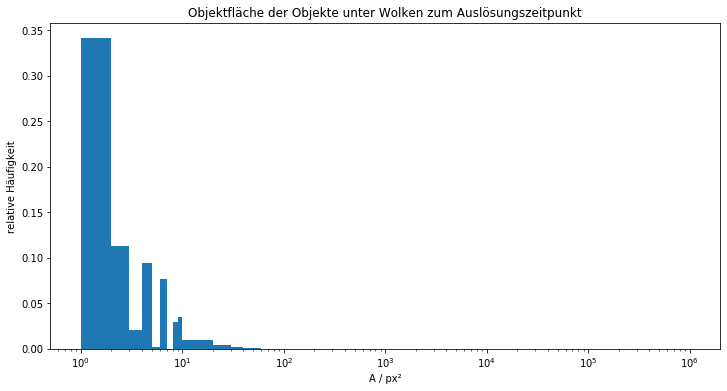

In [4]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
(xb,yb,nb) = ax.hist(haci_full_filtered[haci_full_filtered.in_cloud==1].area0.values,
                     bins=[i for i in np.arange(1,11)] + 
                          [i for i in np.arange(10,110,10)] +
                          [i for i in np.arange(100,1100,100)] +
                          [i for i in np.arange(1000,11000,1000)]+
                          [i for i in np.arange(10000,110000,10000)]+
                          [i for i in np.arange(100000,1100000,100000)],
                     density=True)
ax.set_xscale("log")
ax.set_xlabel(r"A / px²")
ax.set_ylabel("relative Häufigkeit")
ax.set_title("Objektfläche der Objekte unter Wolken zum Auslösungszeitpunkt")

Text(0.5, 1.0, 'Objektfläche der Objekte außerhalb von Wolken zum Auslösungszeitpunkt')

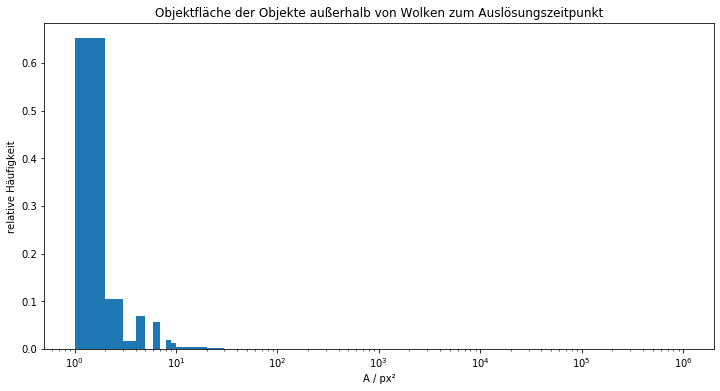

In [6]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
(xb,yb,nb) = ax.hist(haci_full_filtered[haci_full_filtered.in_cloud==0].area0.values,
                     bins=[i for i in np.arange(1,11)] + 
                          [i for i in np.arange(10,110,10)] +
                          [i for i in np.arange(100,1100,100)] +
                          [i for i in np.arange(1000,11000,1000)]+
                          [i for i in np.arange(10000,110000,10000)]+
                          [i for i in np.arange(100000,1100000,100000)],
                     density=True)
ax.set_xscale("log")
ax.set_xlabel(r"A / px²")
ax.set_ylabel("relative Häufigkeit")
ax.set_title("Objektfläche der Objekte außerhalb von Wolken zum Auslösungszeitpunkt")

In [7]:
haci_full_filtered[haci_full_filtered.in_cloud==1].area0.describe(percentiles=[i for i in np.arange(0.1,1,0.05)])

count                 212990.000000
mean                     893.185633
std                    11015.215561
min                        1.000000
10%                        1.000000
15.0%                      1.000000
20.0%                      1.000000
25.0%                      1.000000
30.0%                      1.000000
35.0%                      2.000000
40.00000000000002%         2.000000
45.0%                      2.000000
50%                        4.000000
50.00000000000001%         4.000000
55.00000000000001%         4.000000
60.00000000000002%         6.000000
65.00000000000001%         8.000000
70.00000000000001%         9.000000
75.00000000000003%        12.000000
80.00000000000001%        16.000000
85.00000000000001%        25.000000
90.00000000000003%        50.000000
95.00000000000001%       459.000000
max                   620920.000000
Name: area0, dtype: float64

In [8]:
haci_full_filtered[haci_full_filtered.in_cloud==0].area0.describe(percentiles=[i for i in np.arange(0.1,1,0.05)])

count                  12835.000000
mean                     424.713751
std                     9006.723195
min                        1.000000
10%                        1.000000
15.0%                      1.000000
20.0%                      1.000000
25.0%                      1.000000
30.0%                      1.000000
35.0%                      1.000000
40.00000000000002%         1.000000
45.0%                      1.000000
50%                        1.000000
50.00000000000001%         1.000000
55.00000000000001%         1.000000
60.00000000000002%         1.000000
65.00000000000001%         1.000000
70.00000000000001%         2.000000
75.00000000000003%         2.000000
80.00000000000001%         4.000000
85.00000000000001%         6.000000
90.00000000000003%         7.000000
95.00000000000001%        12.000000
max                   489616.000000
Name: area0, dtype: float64

Es sieht so aus, als wäre die bisher verwendete Filterung nach der Anfangsfläche eingermaßen, aber nicht besonders geeignet, um meteorologische und nichtmeteorlogische Radarechos zu trennen. 

Die Echos, die unter Wolken liegen sind im Mittel etwa doppelt so groß, wie die, die nicht unter Wolken liegen. Tendenziell haben mehr als 90&thinsp;% der Radarechos, die außerhalb von Wolken liegen eine Fläche von weniger als 10&thinsp;px<sup>2</sup>, aber es gibt auch riesige Echos außerhalb von Wolken. Mehr als 65&thinsp;% dieser Radarechos haben eine Fläche von weniger als 2&thinsp;px<sup>2</sup>.

Allerdings haben etwa 30&thinsp;% der Echos unter Wolken zu Anfang auch nur eine Fläche von 1&thinsp;px<sup>2</sup>.
Der bisher verwendete Schwellwert von mindestens 10&thinsp;px<sup>2</sup> schließt ca. 70&thinsp;% der Kandidaten für echte isolierte konvektive Objekte aus. 


## 5.2 Flächenänderung über die Zeit

Nur weil ein Echo unter oder nahe einer Wolke liegt, muss das auch noch nicht heißen, dass es sich dabei um ein nichtmeteorologisches Echo handelt, aber es ist ein stärkeres Indiz, als nur die Fläche allein. Das stärkere zusätzliche Indiz ist wahrscheinlich die Flächenänderung über die Zeit. Die Fläche von tatsächlichen meteorologischen Niederschlagsechos sollte sich über die Zeit betrachtete Zeit von 30&thinsp;min ändern, während die Fläche der nichtmeteorologische Echos in etwa konstant bleiben sollte.

(0, 0.15)

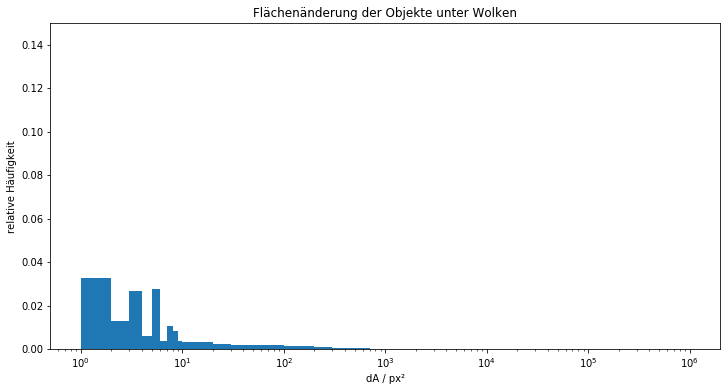

In [70]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
(xb,yb,nb) = ax.hist(haci_full_filtered[haci_full_filtered.in_cloud==1].darea.values,
                     bins=[i for i in np.arange(1,11)] + 
                          [i for i in np.arange(10,110,10)] +
                          [i for i in np.arange(100,1100,100)] +
                          [i for i in np.arange(1000,11000,1000)]+
                          [i for i in np.arange(10000,110000,10000)]+
                          [i for i in np.arange(100000,1100000,100000)],
                     density=True)
ax.set_xscale("log")
ax.set_xlabel(r"dA / px²")
ax.set_ylabel("relative Häufigkeit")
ax.set_title("Flächenänderung der Objekte unter Wolken")
ax.set_ylim(0,0.15)

(0, 0.15)

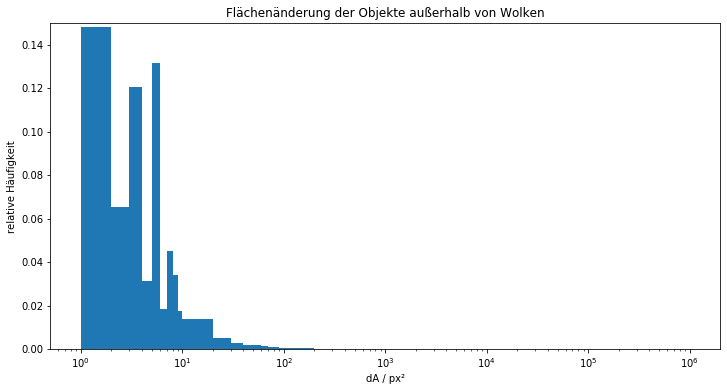

In [71]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
(xb,yb,nb) = ax.hist(haci_full_filtered[haci_full_filtered.in_cloud==0].darea.values,
                     bins=[i for i in np.arange(1,11)] + 
                          [i for i in np.arange(10,110,10)] +
                          [i for i in np.arange(100,1100,100)] +
                          [i for i in np.arange(1000,11000,1000)]+
                          [i for i in np.arange(10000,110000,10000)]+
                          [i for i in np.arange(100000,1100000,100000)],
                     density=True)
ax.set_xscale("log")
ax.set_xlabel(r"dA / px²")
ax.set_ylabel("relative Häufigkeit")
ax.set_title("Flächenänderung der Objekte außerhalb von Wolken")
ax.set_ylim(0,0.15)

In [9]:
haci_full_filtered[haci_full_filtered.in_cloud==1].darea.describe(percentiles=[i for i in np.arange(0.1,1,0.05)])

count                 212990.000000
mean                    2059.623414
std                     8487.751086
min                        0.000000
10%                        0.000000
15.0%                      3.000000
20.0%                      6.000000
25.0%                     19.000000
30.0%                     46.000000
35.0%                     74.000000
40.00000000000002%       104.000000
45.0%                    140.000000
50%                      183.000000
50.00000000000001%       183.000000
55.00000000000001%       239.000000
60.00000000000002%       316.000000
65.00000000000001%       418.000000
70.00000000000001%       569.000000
75.00000000000003%       802.750000
80.00000000000001%      1194.000000
85.00000000000001%      1928.000000
90.00000000000003%      3582.100000
95.00000000000001%      8842.550000
max                   282348.000000
Name: darea, dtype: float64

In [73]:
haci_full_filtered[haci_full_filtered.in_cloud==0].darea.describe(percentiles=[i for i in np.arange(0.1,1,0.05)])

count     12835.000000
mean        415.850954
std        6038.291057
min           0.000000
10%           0.000000
15%           0.000000
20%           0.000000
25%           0.000000
30%           0.000000
35%           1.000000
40%           1.000000
45%           2.000000
50%           3.000000
50%           3.000000
55%           3.000000
60%           5.000000
65%           5.000000
70%           7.000000
75%          11.000000
80%          15.000000
85%          23.000000
90%          49.000000
95%         125.600000
max      310184.000000
Name: darea, dtype: float64

Es gibt sowohl bei den Radarechos unter Wolken, aber auch bei denen außerhalb von Wolken Flächenzunahmen und es gibt bei beiden Kategorien auch Radarechos, die nicht wachsen. Für die Radarechos außerhalb von Wolken ist der Anteil derer, die nicht wachsen mit mehr als 30&thinsp;% gegenüber weniger als 15&thinsp;% etwa doppelt so hoch, wie bei denen unter Wolken. Die Radarechos, die unter Wolken liegen, aber nicht wachsen können wohl ausgeschlossen werden, aber der bisher verwendete Schwellwert von mehr als 100&thinsp;px<sup>2</sup> über eine halbe Stunde schließt mehr als 35&thinsp;% der möglichen Objektkandidaten aus. Das ist aber wahrscheinlich akzeptabel.

Problematischer sind die ca. 75&thinsp;% von Radarechos, die nicht unter Wolken liegen, aber wachsen. Ist das ein Problem beim Ansatz, wie die bewölkten Pixel zugeordnet werden, oder sind das einfach wachsende, nichtmeteorologische Echos? Um das zu klären, sollten wir uns einige dieser Objekte ansehen.